# DWD Weather Station Data

In [1]:
import os
import requests
import bz2
import gzip
import pygrib
import shutil
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

<b>Weather Stations in Germany for:</b></br></br>
relative humidity (%)</br>
air pressure at station level (hPa)</br>
air temperature near ground (°C)</br>
air temperature at 2 m (°C)</br>
dew point temperature (°C)

In [2]:
directory = 'data/air_temperature'

column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]


files = os.listdir(directory)
stations_path = [f for f in files if "Stationen" in f][0]

stations = pd.read_fwf(os.path.join(directory, stations_path), 
                       encoding='latin1',
                       skiprows=2,
                       names=column_names)

#stations.drop(['Frei'], axis=1, inplace=True)

In [3]:
stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Abgabe
0,3,19930429,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,Frei
1,44,20070209,20241126,44,52.9336,8.2370,Großenkneten,Niedersachsen,Frei
2,71,20091201,20191231,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg,Frei
3,73,20070215,20241126,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern,Frei
4,78,20041012,20241126,64,52.4853,7.9125,Alfhausen,Niedersachsen,Frei
...,...,...,...,...,...,...,...,...,...
515,15813,20220301,20241126,40,52.5126,7.4131,Lingen-Baccum,Niedersachsen,Frei
516,19171,20200901,20241126,13,54.0039,9.8555,Hasenkrug-Hardebek,Schleswig-Holstein,Frei
517,19172,20200901,20241126,48,54.0246,9.3880,Wacken,Schleswig-Holstein,Frei
518,19207,20230401,20241126,16,53.8178,12.0645,Gülzow-Prüzen,Mecklenburg-Vorpommern,Frei


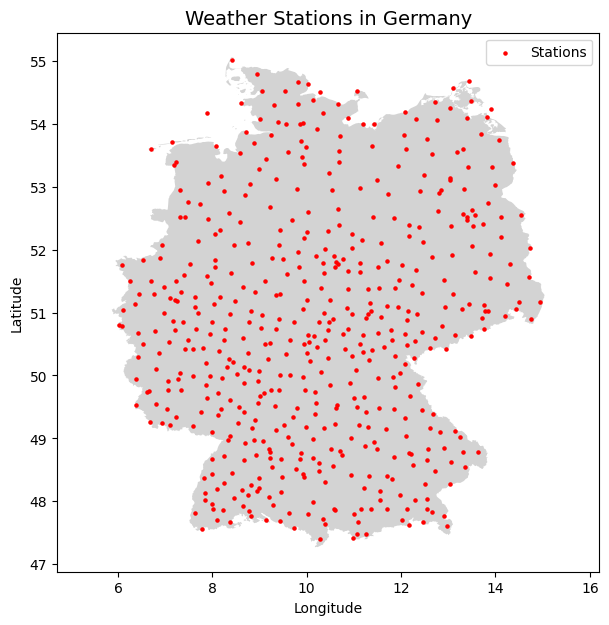

In [26]:
germany = gpd.read_file('geoBoundaries-DE.geojson')

geometry = [Point(xy) for xy in zip(stations['geoLaenge'], stations['geoBreite'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, color='red', markersize=5, label='Stations')

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Weather Stations in Germany', fontsize=14)
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [28]:
file = files[0]

df = pd.read_csv(os.path.join(directory, file), sep=';')

df['timestamp'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H%M')
df.set_index('timestamp', inplace=True)
df.drop(['MESS_DATUM'], axis=1, inplace=True)

In [29]:
df

,STATIONS_ID,QN,PP_10,TT_10,TM5_10,RF_10,TD_10,eor
timestamp,,,,,,,,
2023-05-26 00:00:00,1224,3,-999,10.6,8.9,94.0,9.7,eor
2023-05-26 00:10:00,1224,3,-999,10.8,9.2,94.3,9.9,eor
2023-05-26 00:20:00,1224,3,-999,11.1,9.2,92.8,10.0,eor
2023-05-26 00:30:00,1224,3,-999,10.9,8.7,92.0,9.7,eor
2023-05-26 00:40:00,1224,3,-999,10.6,8.8,93.0,9.5,eor
...,...,...,...,...,...,...,...,...
2024-11-25 23:10:00,1224,2,-999,11.5,11.0,96.5,11.0,eor
2024-11-25 23:20:00,1224,2,-999,11.3,11.0,96.7,10.8,eor
2024-11-25 23:30:00,1224,2,-999,11.5,11.0,95.4,10.8,eor
